## Fixed-tilt Bifacial Modeling - modelchain, in order to find a way to calculate irradiance over crops between bifacial modules

Use location of Vancouver here.

##### Based on https://pvlib-python.readthedocs.io/en/stable/gallery/bifacial/plot_pvfactors_fixed_tilt.html#sphx-glr-gallery-bifacial-plot-pvfactors-fixed-tilt-py and https://pvlib-python.readthedocs.io/en/stable/gallery/bifacial/plot_bifi_model_mc.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import pandas as pd
from pvlib import location
from pvlib.bifacial.pvfactors import pvfactors_timeseries
import matplotlib.pyplot as plt
import warnings

# supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')

In [4]:
from pvlib import pvsystem
from pvlib import modelchain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS as PARAMS

### Get irradiance

In [5]:
times = pd.date_range('2022-07-06', '2022-07-07', freq='1T', 
                      tz='Canada/Pacific')
#times = pd.date_range('2022-07-06', '2022-07-07', freq='1T', tz='Etc/GMT+7')
loc = location.Location(latitude=49.26757152616243, 
                        longitude=-123.25266177347093, tz=times.tz)
sp = loc.get_solarposition(times)
cs = loc.get_clearsky(times)

# example array geometry
pvrow_height = 1
pvrow_width = 4
pitch = 10
gcr = pvrow_width / pitch
axis_azimuth = 180
albedo = 0.2

In [6]:
type(times)

pandas.core.indexes.datetimes.DatetimeIndex

In [7]:
times

DatetimeIndex(['2022-07-06 00:00:00-07:00', '2022-07-06 00:01:00-07:00',
               '2022-07-06 00:02:00-07:00', '2022-07-06 00:03:00-07:00',
               '2022-07-06 00:04:00-07:00', '2022-07-06 00:05:00-07:00',
               '2022-07-06 00:06:00-07:00', '2022-07-06 00:07:00-07:00',
               '2022-07-06 00:08:00-07:00', '2022-07-06 00:09:00-07:00',
               ...
               '2022-07-06 23:51:00-07:00', '2022-07-06 23:52:00-07:00',
               '2022-07-06 23:53:00-07:00', '2022-07-06 23:54:00-07:00',
               '2022-07-06 23:55:00-07:00', '2022-07-06 23:56:00-07:00',
               '2022-07-06 23:57:00-07:00', '2022-07-06 23:58:00-07:00',
               '2022-07-06 23:59:00-07:00', '2022-07-07 00:00:00-07:00'],
              dtype='datetime64[ns, Canada/Pacific]', length=1441, freq='T')

In [8]:
times.tz

<DstTzInfo 'Canada/Pacific' LMT-1 day, 15:48:00 STD>

In [9]:
sp

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2022-07-06 00:00:00-07:00,105.997064,105.997064,-15.997064,-15.997064,341.362505,-4.778212
2022-07-06 00:01:00-07:00,106.048944,106.048944,-16.048944,-16.048944,341.596318,-4.778328
2022-07-06 00:02:00-07:00,106.100192,106.100192,-16.100192,-16.100192,341.830342,-4.778444
2022-07-06 00:03:00-07:00,106.150806,106.150806,-16.150806,-16.150806,342.064576,-4.778561
2022-07-06 00:04:00-07:00,106.200787,106.200787,-16.200787,-16.200787,342.299017,-4.778677
...,...,...,...,...,...,...
2022-07-06 23:56:00-07:00,105.875532,105.875532,-15.875532,-15.875532,340.365441,-4.941988
2022-07-06 23:57:00-07:00,105.930100,105.930100,-15.930100,-15.930100,340.598639,-4.942100
2022-07-06 23:58:00-07:00,105.984042,105.984042,-15.984042,-15.984042,340.832057,-4.942212
2022-07-06 23:59:00-07:00,106.037357,106.037357,-16.037357,-16.037357,341.065694,-4.942323


<AxesSubplot:>

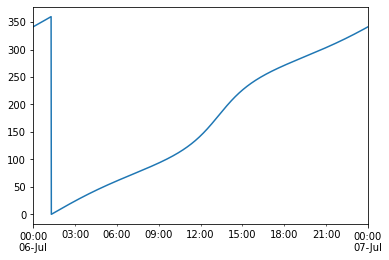

In [10]:
sp['azimuth'].plot()

In [11]:
cs

,ghi,dni,dhi
2022-07-06 00:00:00-07:00,0.0,0.0,0.0
2022-07-06 00:01:00-07:00,0.0,0.0,0.0
2022-07-06 00:02:00-07:00,0.0,0.0,0.0
2022-07-06 00:03:00-07:00,0.0,0.0,0.0
2022-07-06 00:04:00-07:00,0.0,0.0,0.0
...,...,...,...
2022-07-06 23:56:00-07:00,0.0,0.0,0.0
2022-07-06 23:57:00-07:00,0.0,0.0,0.0
2022-07-06 23:58:00-07:00,0.0,0.0,0.0
2022-07-06 23:59:00-07:00,0.0,0.0,0.0


<AxesSubplot:>

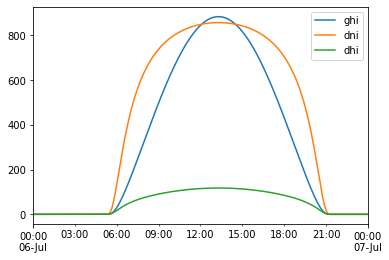

In [12]:
cs.plot()

In [13]:
irrad = pvfactors_timeseries(
    solar_azimuth=sp['azimuth'],
    solar_zenith=sp['apparent_zenith'],
    surface_azimuth=180,  # south-facing array
    surface_tilt=20,
    axis_azimuth=90,  # 90 degrees off from surface_azimuth.  270 is ok too
    timestamps=times,
    dni=cs['dni'],
    dhi=cs['dhi'],
    gcr=gcr,
    pvrow_height=pvrow_height,
    pvrow_width=pvrow_width,
    albedo=albedo,
    n_pvrows=3,
    index_observed_pvrow=1
)

In [14]:
irrad

(2022-07-06 00:00:00-07:00    0.0
 2022-07-06 00:01:00-07:00    0.0
 2022-07-06 00:02:00-07:00    0.0
 2022-07-06 00:03:00-07:00    0.0
 2022-07-06 00:04:00-07:00    0.0
                             ... 
 2022-07-06 23:56:00-07:00    0.0
 2022-07-06 23:57:00-07:00    0.0
 2022-07-06 23:58:00-07:00    0.0
 2022-07-06 23:59:00-07:00    0.0
 2022-07-07 00:00:00-07:00    0.0
 Freq: T, Name: total_inc_front, Length: 1441, dtype: float64,
 2022-07-06 00:00:00-07:00    0.0
 2022-07-06 00:01:00-07:00    0.0
 2022-07-06 00:02:00-07:00    0.0
 2022-07-06 00:03:00-07:00    0.0
 2022-07-06 00:04:00-07:00    0.0
                             ... 
 2022-07-06 23:56:00-07:00    0.0
 2022-07-06 23:57:00-07:00    0.0
 2022-07-06 23:58:00-07:00    0.0
 2022-07-06 23:59:00-07:00    0.0
 2022-07-07 00:00:00-07:00    0.0
 Freq: T, Name: total_inc_back, Length: 1441, dtype: float64,
 2022-07-06 00:00:00-07:00    0.0
 2022-07-06 00:01:00-07:00    0.0
 2022-07-06 00:02:00-07:00    0.0
 2022-07-06 00:03:00-07:0

In [15]:
len(irrad)

4

In [16]:
type(irrad)

tuple

In [17]:
irrad[0]

2022-07-06 00:00:00-07:00    0.0
2022-07-06 00:01:00-07:00    0.0
2022-07-06 00:02:00-07:00    0.0
2022-07-06 00:03:00-07:00    0.0
2022-07-06 00:04:00-07:00    0.0
                            ... 
2022-07-06 23:56:00-07:00    0.0
2022-07-06 23:57:00-07:00    0.0
2022-07-06 23:58:00-07:00    0.0
2022-07-06 23:59:00-07:00    0.0
2022-07-07 00:00:00-07:00    0.0
Freq: T, Name: total_inc_front, Length: 1441, dtype: float64

In [18]:
type(irrad[0])

pandas.core.series.Series

In [19]:
irrad[1]

2022-07-06 00:00:00-07:00    0.0
2022-07-06 00:01:00-07:00    0.0
2022-07-06 00:02:00-07:00    0.0
2022-07-06 00:03:00-07:00    0.0
2022-07-06 00:04:00-07:00    0.0
                            ... 
2022-07-06 23:56:00-07:00    0.0
2022-07-06 23:57:00-07:00    0.0
2022-07-06 23:58:00-07:00    0.0
2022-07-06 23:59:00-07:00    0.0
2022-07-07 00:00:00-07:00    0.0
Freq: T, Name: total_inc_back, Length: 1441, dtype: float64

In [20]:
# turn into pandas DataFrame
irrad_df = pd.concat(irrad, axis=1)

In [21]:
irrad_df

,total_inc_front,total_inc_back,total_abs_front,total_abs_back
2022-07-06 00:00:00-07:00,0.0,0.0,0.0,0.0
2022-07-06 00:01:00-07:00,0.0,0.0,0.0,0.0
2022-07-06 00:02:00-07:00,0.0,0.0,0.0,0.0
2022-07-06 00:03:00-07:00,0.0,0.0,0.0,0.0
2022-07-06 00:04:00-07:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2022-07-06 23:56:00-07:00,0.0,0.0,0.0,0.0
2022-07-06 23:57:00-07:00,0.0,0.0,0.0,0.0
2022-07-06 23:58:00-07:00,0.0,0.0,0.0,0.0
2022-07-06 23:59:00-07:00,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Irradiance [W m$^{-2}$]')

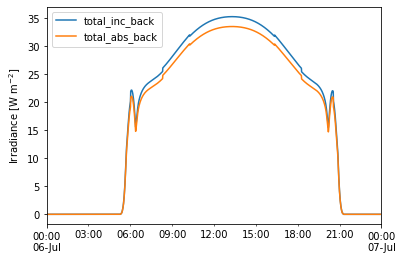

In [22]:
irrad_df[['total_inc_back', 'total_abs_back']].plot()
plt.ylabel('Irradiance [W m$^{-2}$]')

Text(0, 0.5, 'Irradiance [W m$^{-2}$]')

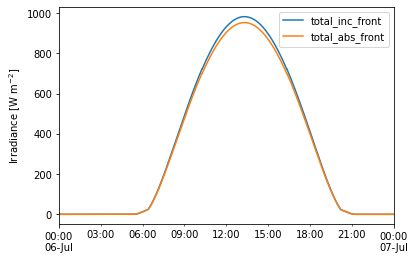

In [23]:
irrad_df[['total_inc_front', 'total_abs_front']].plot()
plt.ylabel('Irradiance [W m$^{-2}$]')

In [24]:
bifaciality = 0.75

In [25]:
# create bifacial effective irradiance using aoi-corrected timeseries values
irrad_df['effective_irradiance'] = (
    irrad_df['total_abs_front'] + (irrad_df['total_abs_back'] * bifaciality)
)

In [26]:
irrad_df

,total_inc_front,total_inc_back,total_abs_front,total_abs_back,effective_irradiance
2022-07-06 00:00:00-07:00,0.0,0.0,0.0,0.0,0.0
2022-07-06 00:01:00-07:00,0.0,0.0,0.0,0.0,0.0
2022-07-06 00:02:00-07:00,0.0,0.0,0.0,0.0,0.0
2022-07-06 00:03:00-07:00,0.0,0.0,0.0,0.0,0.0
2022-07-06 00:04:00-07:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2022-07-06 23:56:00-07:00,0.0,0.0,0.0,0.0,0.0
2022-07-06 23:57:00-07:00,0.0,0.0,0.0,0.0,0.0
2022-07-06 23:58:00-07:00,0.0,0.0,0.0,0.0,0.0
2022-07-06 23:59:00-07:00,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Irradiance [W m$^{-2}$]')

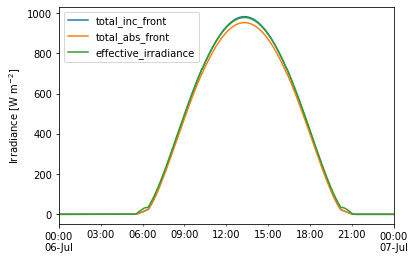

In [27]:
irrad_df[['total_inc_front', 'total_abs_front', 'effective_irradiance']
        ].plot()
plt.ylabel('Irradiance [W m$^{-2}$]')

In [28]:
irrad_df[700:704]

,total_inc_front,total_inc_back,total_abs_front,total_abs_back,effective_irradiance
2022-07-06 11:40:00-07:00,903.295998,34.399309,876.197118,32.679343,900.706625
2022-07-06 11:41:00-07:00,904.872874,34.418901,877.726688,32.697956,902.250155
2022-07-06 11:42:00-07:00,906.434674,34.438232,879.241634,32.716321,903.778875
2022-07-06 11:43:00-07:00,907.981362,34.457305,880.741921,32.734440,905.292751


In [29]:
times[700:704]

DatetimeIndex(['2022-07-06 11:40:00-07:00', '2022-07-06 11:41:00-07:00',
               '2022-07-06 11:42:00-07:00', '2022-07-06 11:43:00-07:00'],
              dtype='datetime64[ns, Canada/Pacific]', freq='T')

In [30]:
index = times[700:704]
data = {'total_inc_front': [903.2, 904.8, 906.4, 907.9],
        'total_inc_back': [34.3, 34.4, 34.4, 34.4],
        'total_abs_front': [876.1, 877.7, 879.2, 880.7],
        'total_abs_back': [32.6, 32.6, 32.7, 32.7],
        'effective_irradiance': [900.7, 902.2, 903.7, 905.2]}
bifacial_irradiances_2 = pd.DataFrame(data, index=index)
bifacial_irradiances_2

,total_inc_front,total_inc_back,total_abs_front,total_abs_back,effective_irradiance
2022-07-06 11:40:00-07:00,903.2,34.3,876.1,32.6,900.7
2022-07-06 11:41:00-07:00,904.8,34.4,877.7,32.6,902.2
2022-07-06 11:42:00-07:00,906.4,34.4,879.2,32.7,903.7
2022-07-06 11:43:00-07:00,907.9,34.4,880.7,32.7,905.2


In [31]:
bifacial_irradiances_2['total_inc_back'] / albedo * (1 - albedo)

2022-07-06 11:40:00-07:00    137.2
2022-07-06 11:41:00-07:00    137.6
2022-07-06 11:42:00-07:00    137.6
2022-07-06 11:43:00-07:00    137.6
Freq: T, Name: total_inc_back, dtype: float64

In [32]:
surface_tilt = np.radians(20)
(bifacial_irradiances_2['total_inc_back'] * np.cos(surface_tilt)).to_frame(
    name='ground_absorbed_irradiance')

,ground_absorbed_irradiance
2022-07-06 11:40:00-07:00,32.231457
2022-07-06 11:41:00-07:00,32.325426
2022-07-06 11:42:00-07:00,32.325426
2022-07-06 11:43:00-07:00,32.325426


In [33]:
(bifacial_irradiances_2['total_inc_back'] / albedo * (1 - albedo)).to_frame(
    name='ground_absorbed_irradiance').iloc[0][
            'ground_absorbed_irradiance']

137.2

In [34]:
surface_tilt

0.3490658503988659

In [35]:
np.cos(surface_tilt)

0.9396926207859084

### Get module and inverter related data

In [36]:
latitude=49.26757152616243
longitude=-123.25266177347093

In [37]:
# load temperature parameters and module/inverter specifications
temp_model_parameters = PARAMS['sapm']['open_rack_glass_glass']
cec_modules = pvsystem.retrieve_sam('CECMod')
cec_module = cec_modules['Trina_Solar_TSM_300DEG5C_07_II_']
cec_inverters = pvsystem.retrieve_sam('cecinverter')
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [38]:
temp_model_parameters

{'a': -3.47, 'b': -0.0594, 'deltaT': 3}

In [39]:
cec_module

Technology            Mono-c-Si
Bifacial                      1
STC                     300.217
PTC                       278.9
A_c                        1.65
Length                      NaN
Width                       NaN
N_s                          60
I_sc_ref                   9.68
V_oc_ref                   40.1
I_mp_ref                   9.07
V_mp_ref                   33.1
alpha_sc               0.003775
beta_oc               -0.109874
T_NOCT                     43.4
a_ref                  1.545676
I_L_ref                 9.69201
I_o_ref                     0.0
R_s                    0.251086
R_sh_ref             202.374603
Adjust                13.491088
gamma_r                  -0.384
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Trina_Solar_TSM_300DEG5C_07_II_, dtype: object

In [40]:
cec_inverter

Vac                          208
Pso                     2.089607
Paco                       250.0
Pdco                  259.588593
Vdco                        40.0
C0                     -0.000041
C1                     -0.000091
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                      50.0
Idcmax                  6.489715
Mppt_low                    30.0
Mppt_high                   50.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

### Get model and perform bifacial simulation

In [41]:
surface_tilt=20
surface_azimuth=180

In [42]:
fixed_mount = pvsystem.FixedMount(surface_tilt, surface_azimuth)

In [43]:
# dc arrays
array = pvsystem.Array(mount=fixed_mount,
                       module_parameters=cec_module,
                       temperature_model_parameters=temp_model_parameters)

In [44]:
# create system object
system = pvsystem.PVSystem(arrays=[array],
                           inverter_parameters=cec_inverter)

In [47]:
site_location = loc
# ModelChain requires the parameter aoi_loss to have a value. pvfactors
# applies surface reflection models in the calculation of front and back
# irradiance, so assign aoi_model='no_loss' to avoid double counting
# reflections.
mc_bifi = modelchain.ModelChain(system, site_location, aoi_model='no_loss')

In [48]:
mc_bifi

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [49]:
mc_bifi.run_model_from_effective_irradiance(irrad_df)

/Users/tadatoshi/Documents/development/projects/tadatoshi_solar_research_society/agrivoltaics_supply_side_management/venv/lib/python3.10/site-packages/pvlib/tools.py:340: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

<AxesSubplot:title={'center':'Bifacial Simulation on June Solstice'}, ylabel='AC Power'>

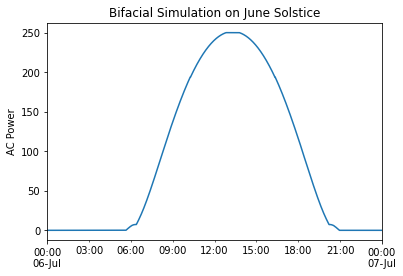

In [50]:
# plot results
mc_bifi.results.ac.plot(title='Bifacial Simulation on June Solstice',
                        ylabel='AC Power')

In [51]:
mc_bifi.results

ModelChainResult(_singleton_tuples=False, solar_position=None, airmass=None, ac=2022-07-06 00:00:00-07:00   -0.075
2022-07-06 00:01:00-07:00   -0.075
2022-07-06 00:02:00-07:00   -0.075
2022-07-06 00:03:00-07:00   -0.075
2022-07-06 00:04:00-07:00   -0.075
                             ...  
2022-07-06 23:56:00-07:00   -0.075
2022-07-06 23:57:00-07:00   -0.075
2022-07-06 23:58:00-07:00   -0.075
2022-07-06 23:59:00-07:00   -0.075
2022-07-07 00:00:00-07:00   -0.075
Freq: T, Length: 1441, dtype: float64, tracking=None, losses=1, total_irrad=Empty DataFrame
Columns: []
Index: [2022-07-06 00:00:00-07:00, 2022-07-06 00:01:00-07:00, 2022-07-06 00:02:00-07:00, 2022-07-06 00:03:00-07:00, 2022-07-06 00:04:00-07:00, 2022-07-06 00:05:00-07:00, 2022-07-06 00:06:00-07:00, 2022-07-06 00:07:00-07:00, 2022-07-06 00:08:00-07:00, 2022-07-06 00:09:00-07:00, 2022-07-06 00:10:00-07:00, 2022-07-06 00:11:00-07:00, 2022-07-06 00:12:00-07:00, 2022-07-06 00:13:00-07:00, 2022-07-06 00:14:00-07:00, 2022-07-06 00:15:0

In [52]:
type(mc_bifi.results)

pvlib.modelchain.ModelChainResult

In [53]:
type(mc_bifi.results.ac)

pandas.core.series.Series